In [2]:
import numpy as np
import pandas as pd
import torch

from torch.nn.attention.flex_attention import flex_attention, create_block_mask, create_mask

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from typing import Iterator

from torch.nn.functional import scaled_dot_product_attention

torch._dynamo.config.cache_size_limit = 1000

In [3]:
def create_mask_mod_naive(stm_window_size: int, mem_freq: int):
    """
    Designed for the use on the input that consists of context states with memory states mixed in.
    Does not support padding!
    """
    
    def causal_window_mask_with_mem(b, h, q_idx, kv_idx):
        is_mem_kv = (kv_idx % mem_freq == 0)
        
        causal = (kv_idx <= q_idx)
        windowed = (q_idx - kv_idx < stm_window_size)
        
        return (
                (~is_mem_kv & causal & windowed) 
                | (is_mem_kv & causal)
        )
    return causal_window_mask_with_mem


In [4]:
def create_mask_mod(context_size: int, stm_window_size: int, mem_freq: int):
    """
    Designed for the use on the input that consists of the concatenation of memory states and context states.
    Does not support padding!
    """
    n_mem = (context_size // mem_freq) + (context_size % mem_freq > 0)  # for block_size = 4: 0, 4, 8, 12, ...
    main_start = n_mem

    mem_end = main_start


    def causal_window_mask_with_mem(b, h, q_idx, kv_idx):
        # differentiator of main from mem parts
        is_mem_kv = (kv_idx < mem_end)
        is_mem_q = (q_idx < mem_end)

        # the first tokens are mem, so we realign with 0
        main_kv_idx = kv_idx - main_start
        main_q_idx = q_idx - main_start

        # mem tokens are really at every mem_freq position
        mem_kv_idx = kv_idx * mem_freq
        mem_q_idx = q_idx * mem_freq

        causal_main_diagonal = (kv_idx <= q_idx)
        main2main_windowed = (main_q_idx - main_kv_idx < stm_window_size)  # [s, e)

        # without window when attending to mem
        # <= to include the diagonal
        main2mem_causal = (mem_kv_idx <= main_q_idx)

        # do not include the diagonal!
        mem2main_causal = (main_kv_idx < mem_q_idx)
        # we did not include the diagonal, so add 1 token more here
        mem2main_windowed = (mem_q_idx - main_kv_idx <= stm_window_size)  # (s, e]

        case_main2main = (~is_mem_kv & ~is_mem_q & causal_main_diagonal & main2main_windowed)
        case_main2mem = (is_mem_kv & ~is_mem_q & main2mem_causal)
        case_mem2mem = (is_mem_kv & is_mem_q & causal_main_diagonal)
        case_mem2main = (~is_mem_kv & is_mem_q & mem2main_causal & mem2main_windowed)
        return case_main2main | case_main2mem | case_mem2mem | case_mem2main  # (3)
    return causal_window_mask_with_mem

In [15]:
def create_mask_mod_exp(context_size: int, stm_window_size: int, mem_freq: int):
    """
    Designed for the use on the input that consists of the concatenation of memory states and context states.
    Does not support padding!
    """
    n_mem = (context_size // mem_freq) + (context_size % mem_freq > 0)  # for block_size = 4: 0, 4, 8, 12, ...
    main_start = n_mem

    mem_end = main_start


    def causal_window_mask_with_mem(b, h, q_idx, kv_idx):
        # differentiator of main from mem parts
        is_mem_kv = (kv_idx < mem_end)
        is_mem_q = (q_idx < mem_end)

        # the first tokens are mem, so we realign with 0
        main_kv_idx = kv_idx - main_start
        main_q_idx = q_idx - main_start

        # mem tokens are really at every mem_freq position
        mem_kv_idx = kv_idx * mem_freq
        mem_q_idx = q_idx * mem_freq

        causal_main_diagonal = (kv_idx <= q_idx)
        main2main_windowed = (main_q_idx - main_kv_idx < stm_window_size)  # [s, e)

        # without window when attending to mem
        # <= to include the diagonal
        main2mem_causal = (mem_kv_idx <= main_q_idx)
        
        dist = (main_q_idx - mem_kv_idx) // mem_freq
        main2mem_exp = (dist == 0) | (dist == 1) | (dist == 2) | (dist == 4) | (dist == 8)| (dist == 16) | (dist == 32) | (dist == 64)
        
        dist = (mem_q_idx - mem_kv_idx) // mem_freq
        mem2mem_exp = (dist == 0) | (dist == 1) | (dist == 2) | (dist == 4) | (dist == 8)| (dist == 16) | (dist == 32) | (dist == 64)

        # do not include the diagonal!
        mem2main_causal = (main_kv_idx < mem_q_idx)
        # we did not include the diagonal, so add 1 token more here
        mem2main_windowed = (mem_q_idx - main_kv_idx <= stm_window_size)  # (s, e]

        case_main2main = (~is_mem_kv & ~is_mem_q & causal_main_diagonal & main2main_windowed)
        case_main2mem = (is_mem_kv & ~is_mem_q & main2mem_causal & main2mem_exp)
        case_mem2mem = (is_mem_kv & is_mem_q & causal_main_diagonal & mem2mem_exp)
        case_mem2main = (~is_mem_kv & is_mem_q & mem2main_causal & mem2main_windowed)
        return case_main2main | case_main2mem | case_mem2mem | case_mem2main  # (3)
    
    return causal_window_mask_with_mem

In [16]:
# visualize
def visualize_mask(mask, title="", block_size=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mask, 
        cmap="Blues", 
        cbar=False, 
        annot=False, 
        square=True,
    )
    
    # Add red grid lines for the block_size
    height, width = mask.shape
    for i in range(0, height, block_size):
        ax.axhline(i, color='red', linewidth=0.5)
    for j in range(0, width, block_size):
        ax.axvline(j, color='red', linewidth=0.5)
    
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

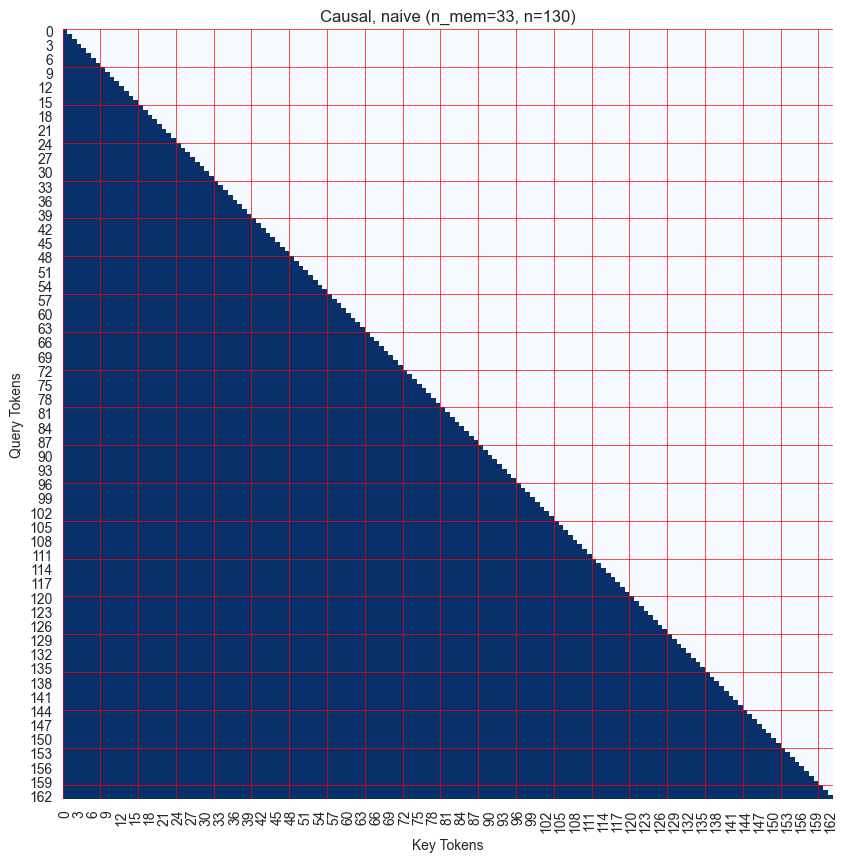

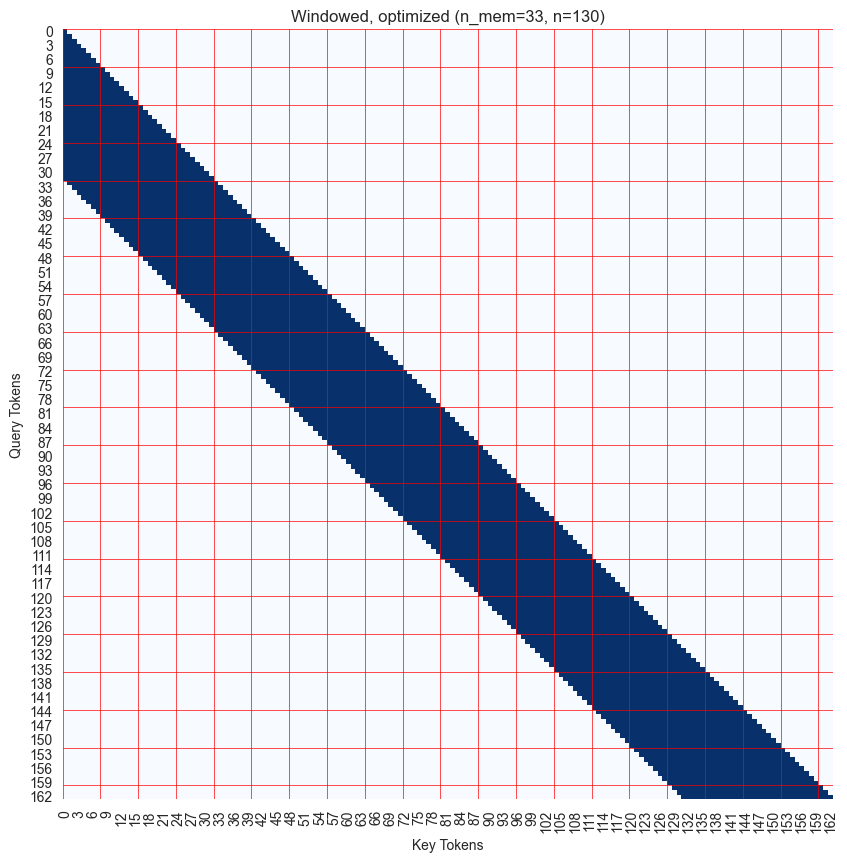

In [17]:
# x4 compression
block_size = 8
stm_window_size = 4 * block_size
mem_freq = 4  # 2 times per block
context = 130

n_mem = (context // mem_freq) + (context % mem_freq > 0)  # 0, 4, 8, 12, ...
def causal_mask_mod(b, h, q_idx, kv_idx):
    return kv_idx <= q_idx

def window_mask_mod(b, h, q_idx, kv_idx):
    return (kv_idx <= q_idx) & (q_idx - kv_idx < stm_window_size)

n = n_mem + context
mask_causal = np.zeros((n, n), dtype=bool)
mask_wind = np.zeros((n, n), dtype=bool)
for q_idx in range(n):
    for kv_idx in range(n):
        q_idx = torch.as_tensor([q_idx])
        kv_idx = torch.as_tensor([kv_idx])
        mask_causal[q_idx, kv_idx] = causal_mask_mod(0, 0, q_idx, kv_idx)
        mask_wind[q_idx, kv_idx] = window_mask_mod(0, 0, q_idx, kv_idx)

visualize_mask(
    mask_causal, 
    title=f'Causal, naive (n_mem={n_mem}, n={context})', 
    block_size=block_size
)
visualize_mask(
    mask_wind, 
    title=f'Windowed, optimized (n_mem={n_mem}, n={context})', 
    block_size=block_size
)

Possible sparsity: 48 - 85


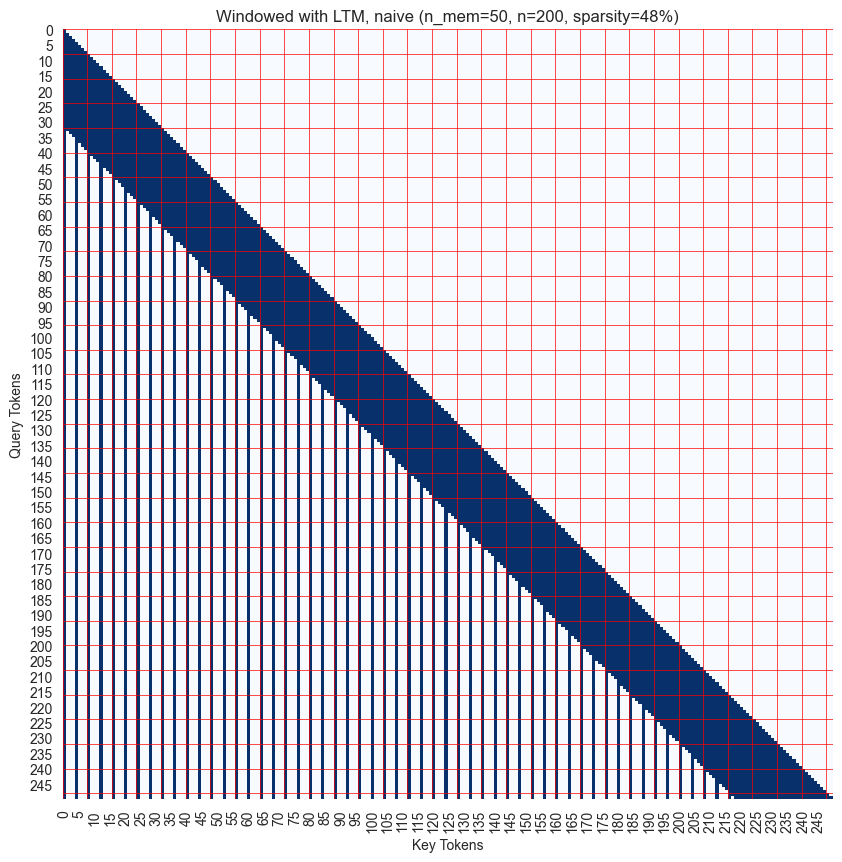

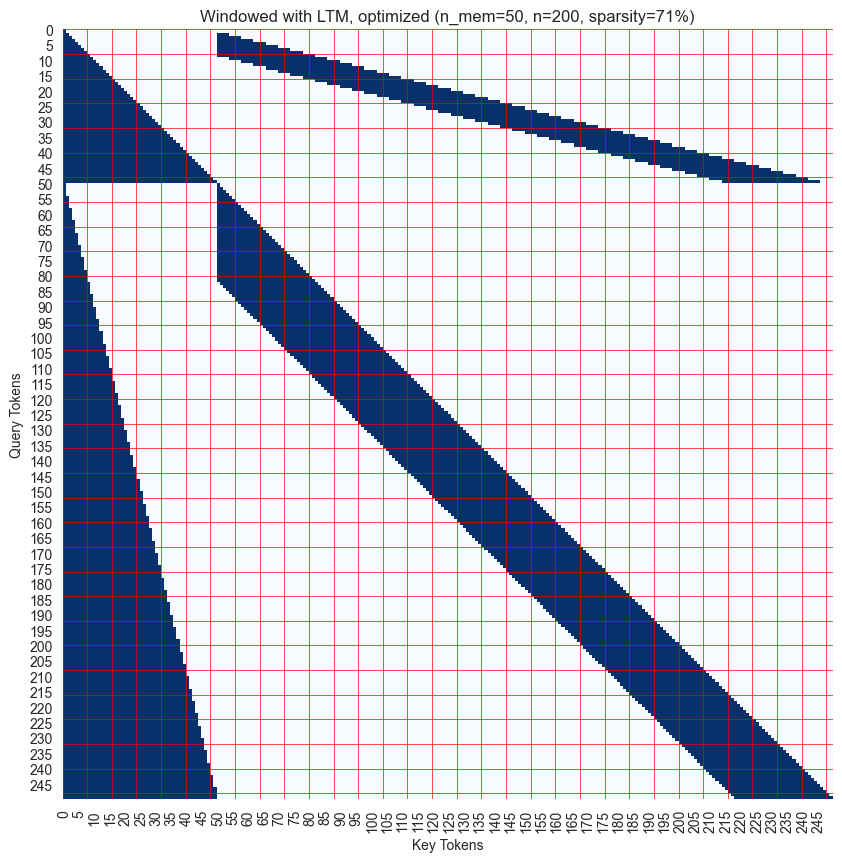

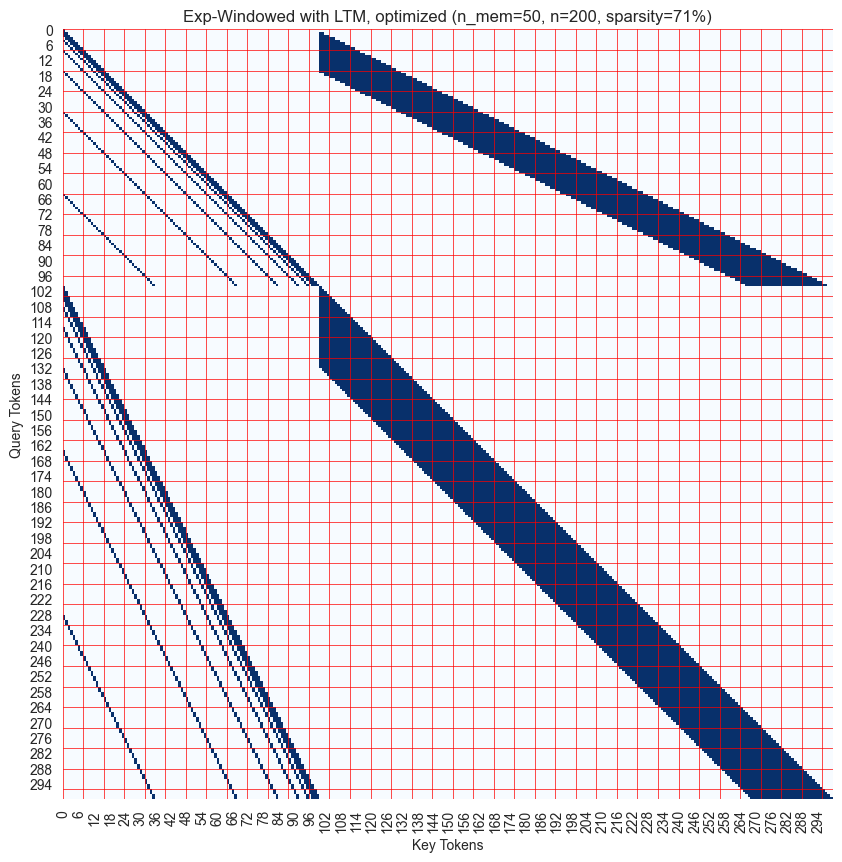

In [18]:
# x4 compression
block_size = 8
stm_window_size = 4 * block_size
mem_freq = 4  # 2 times per block
context = 200

n_mem = (context // mem_freq) + (context % mem_freq > 0)  # 0, 4, 8, 12, ...

mask_mod_opt = create_mask_mod(context, stm_window_size, mem_freq)
mask_mod_naive = create_mask_mod_naive(stm_window_size, mem_freq)
mask_mod_exp = create_mask_mod_exp(context, stm_window_size, 2)

n = n_mem + context
n_exp = context + (context // 2) + (context % 2 > 0)

mask_opt = np.zeros((n, n), dtype=bool)
mask_naive = np.zeros((n, n), dtype=bool)
mask_exp = np.zeros((n_exp, n_exp), dtype=bool)
for q_idx in range(n):
    for kv_idx in range(n):
        q_idx = torch.as_tensor([q_idx])
        kv_idx = torch.as_tensor([kv_idx])
        mask_opt[q_idx, kv_idx] = mask_mod_opt(0, 0, q_idx, kv_idx)
        mask_naive[q_idx, kv_idx] = mask_mod_naive(0, 0, q_idx, kv_idx)

for q_idx in range(n_exp):
    for kv_idx in range(n_exp):
        mask_exp[q_idx, kv_idx] = mask_mod_exp(0, 0, q_idx, kv_idx)

min_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: q_idx >= kv_idx, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
max_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: (q_idx >= kv_idx) & (q_idx - kv_idx < stm_window_size), None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
opt_sparsity = int(create_block_mask(mask_mod_opt, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
naive_sparsity = int(create_block_mask(mask_mod_naive, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())

print(f'Possible sparsity: {min_sparsity} - {max_sparsity}')
visualize_mask(
    mask_naive, 
    title=f'Windowed with LTM, naive (n_mem={n_mem}, n={context}, sparsity={naive_sparsity}%)', 
    block_size=block_size
)
visualize_mask(
    mask_opt, 
    title=f'Windowed with LTM, optimized (n_mem={n_mem}, n={context}, sparsity={opt_sparsity}%)', 
    block_size=block_size
)
visualize_mask(
    mask_exp, 
    title=f'Exp-Windowed with LTM, optimized (n_mem={n_mem}, n={context}, sparsity={opt_sparsity}%)', 
    block_size=block_size
)

Possible sparsity: 48 - 88


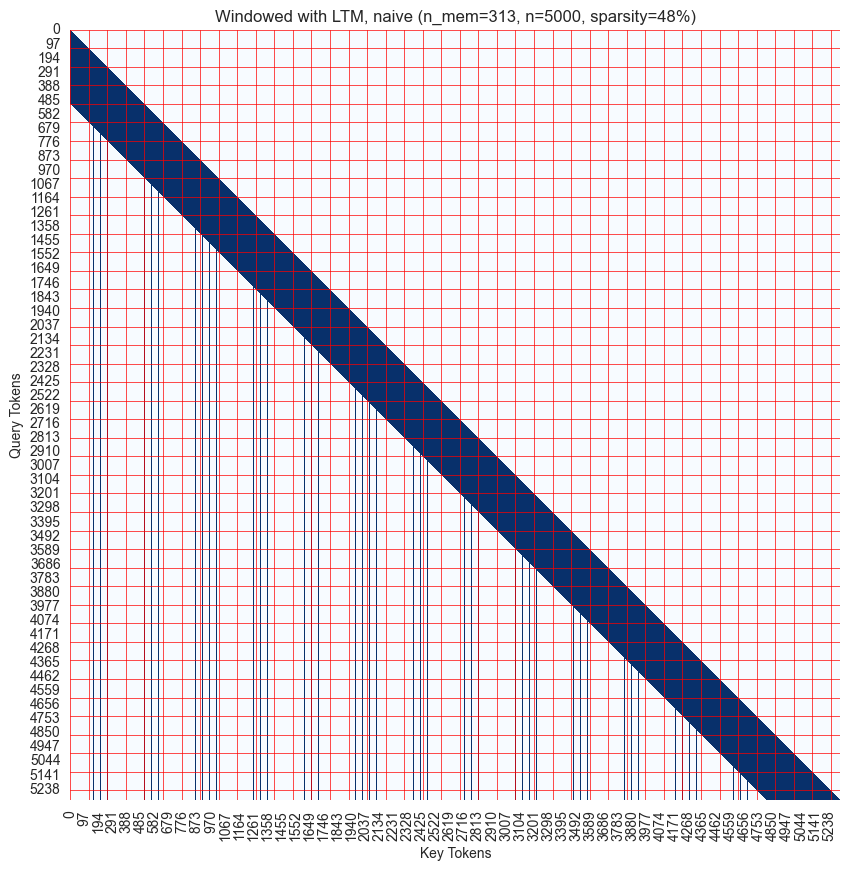

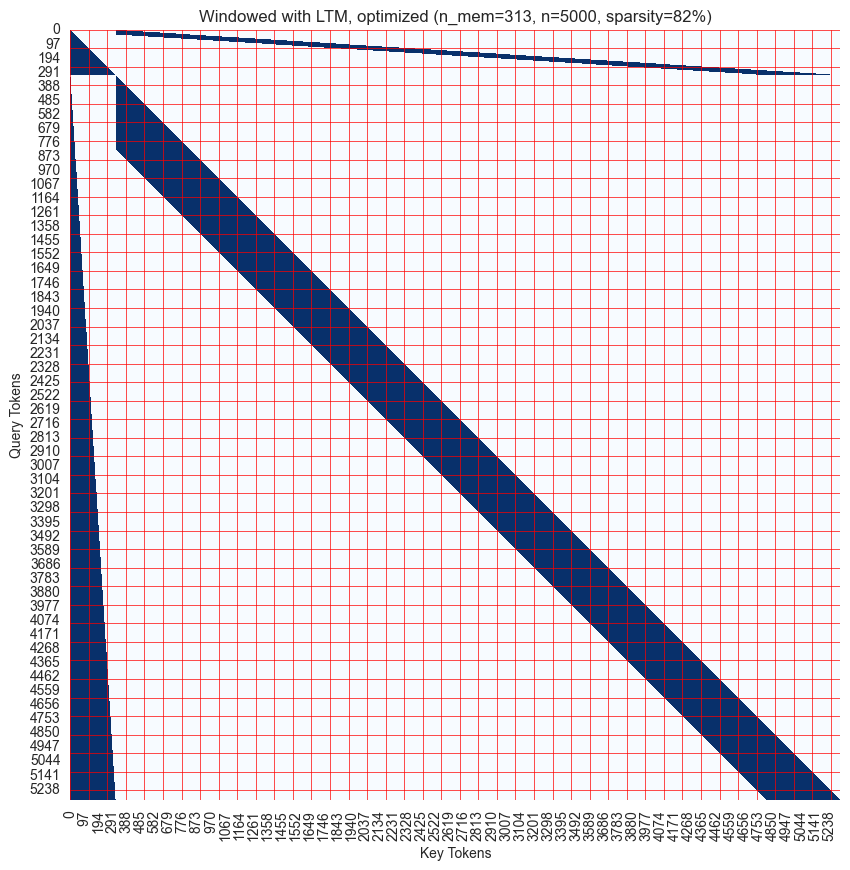

In [45]:
# x16 compression
block_size = 128
stm_window_size = 4 * block_size
mem_freq = 16  # 8 times per block
context = 5000

n_mem = (context // mem_freq) + (context % mem_freq > 0)  # 0, 4, 8, 12, ...

mask_mod_opt = create_mask_mod(context, stm_window_size, mem_freq)
mask_mod_naive = create_mask_mod_naive(stm_window_size, mem_freq)

n = n_mem + context
mask_opt = create_mask(mask_mod_opt, 1, 1, n, n, device='cpu').to_dense()[0, 0, :, :]
mask_naive = create_mask(mask_mod_naive, 1, 1, n, n, device='cpu').to_dense()[0, 0, :, :]

min_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: q_idx >= kv_idx, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
max_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: (q_idx >= kv_idx) & (q_idx - kv_idx < stm_window_size), None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
opt_sparsity = int(create_block_mask(mask_mod_opt, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
naive_sparsity = int(create_block_mask(mask_mod_naive, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())

print(f'Possible sparsity: {min_sparsity} - {max_sparsity}')
visualize_mask(
    mask_naive, 
    title=f'Windowed with LTM, naive (n_mem={n_mem}, n={context}, sparsity={naive_sparsity}%)', 
    block_size=block_size
)
visualize_mask(
    mask_opt, 
    title=f'Windowed with LTM, optimized (n_mem={n_mem}, n={context}, sparsity={opt_sparsity}%)', 
    block_size=block_size
)